# 04 - Model Comparison & Analysis

**Goal**: Compare baseline CNN with transfer learning models and analyze results

**What we'll do**:
1. Load all trained models
2. Evaluate on test set
3. Compare metrics
4. Visualize results
5. Generate final report

## Setup

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import timm
import yaml
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import pandas as pd

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports successful")

✅ Imports successful


In [2]:
import os

# Load config
with open('../configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Paths
PROJECT_ROOT = Path(os.path.dirname(Path.cwd()))
PROCESSED_DIR = PROJECT_ROOT / config['data']['processed_dir']
MODELS_DIR = PROJECT_ROOT / config['paths']['final_models_dir']
RESULTS_DIR = PROJECT_ROOT / config['paths']['results_dir']
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Class names
CLASS_NAMES = config['data']['classes']
NUM_CLASSES = len(CLASS_NAMES)

print(f"\n📁 Directories:")
print(f"  Models: {MODELS_DIR}")
print(f"  Results: {RESULTS_DIR}")

Using device: cuda

📁 Directories:
  Models: /home/steph-grigors/code/steph-grigors/facial-emotion-recognition/models/final
  Results: /home/steph-grigors/code/steph-grigors/facial-emotion-recognition/results


## Load Test Data

In [3]:
# Test transforms (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((config['data']['image_size'][0], config['data']['image_size'][0])),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=config['data']['normalize_mean'],
        std=config['data']['normalize_std']
    )
])

# Load test dataset
test_dataset = datasets.ImageFolder(
    root=str(PROCESSED_DIR / 'test'),
    transform=test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['evaluation']['batch_size'],
    shuffle=False,
    num_workers=4
)

print(f"✅ Test dataset loaded")
print(f"  Total samples: {len(test_dataset)}")
print(f"  Classes: {test_dataset.classes}")

✅ Test dataset loaded
  Total samples: 4978
  Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Define Model Architectures

In [4]:
# Baseline CNN (same as training notebook)
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(BaselineCNN, self).__init__()
        
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.AdaptiveAvgPool2d((7, 7))
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

print("✅ Model architectures defined")

✅ Model architectures defined


## Evaluation Function

In [5]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate a model on the test set
    Returns: accuracy, predictions, true labels
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return accuracy, all_preds, all_labels

print("✅ Evaluation function defined")

✅ Evaluation function defined


## Load and Evaluate Models

**TODO**: Update model paths based on your saved models

In [6]:
# Dictionary to store results
results = {}

# Define models to compare
models_to_compare = [
    {
        'name': 'Baseline CNN',
        'path': MODELS_DIR / 'baseline_cnn_best.pth',
        'architecture': 'baseline'
    },
    # TODO: Add your transfer learning models here
    {
         'name': 'ResNet50',
         'path': MODELS_DIR / 'resnet50_best.pth',
         'architecture': 'resnet50'
    },
    {
         'name': 'EfficientNet-B0',
         'path': MODELS_DIR / 'efficientnet_best.pth',
         'architecture': 'efficientnet'
    },
]

print("📊 Evaluating models...\n")

📊 Evaluating models...



In [9]:
# Evaluate each model
for model_info in models_to_compare:
    name = model_info['name']
    path = model_info['path']
    arch = model_info['architecture']
    
    if not path.exists():
        print(f"⚠️  Skipping {name}: Model file not found at {path}")
        continue
    
    print(f"\n🔍 Evaluating: {name}")
    print(f"   Loading from: {path}")
    
    # Load model
    if arch == 'baseline':
        model = BaselineCNN(num_classes=NUM_CLASSES)
    elif arch == 'resnet50':
        model = models.resnet50(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif arch == 'efficientnet':
        model = timm.create_model("efficientnet_b0", pretrained=False)
        # timm uses just 'classifier', not 'classifier[1]'
        model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)
    
    # Load weights
    model.load_state_dict(torch.load(path, map_location=device))
    model = model.to(device)
    
    # Evaluate
    accuracy, preds, labels = evaluate_model(model, test_loader, device)
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'predictions': preds,
        'labels': labels
    }
    
    print(f"   ✅ Accuracy: {accuracy*100:.2f}%")

print("\n✅ All models evaluated!")


🔍 Evaluating: Baseline CNN
   Loading from: /home/steph-grigors/code/steph-grigors/facial-emotion-recognition/models/final/baseline_cnn_best.pth


Evaluating: 100%|███████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 20.70it/s]
/home/steph-grigors/.pyenv/versions/3.10.6/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/steph-grigors/.pyenv/versions/3.10.6/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


   ✅ Accuracy: 65.81%

🔍 Evaluating: ResNet50
   Loading from: /home/steph-grigors/code/steph-grigors/facial-emotion-recognition/models/final/resnet50_best.pth


Evaluating: 100%|███████████████████████████████████████████████████████████████████████| 78/78 [00:10<00:00,  7.58it/s]


   ✅ Accuracy: 51.49%

🔍 Evaluating: EfficientNet-B0
   Loading from: /home/steph-grigors/code/steph-grigors/facial-emotion-recognition/models/final/efficientnet_best.pth


Evaluating: 100%|███████████████████████████████████████████████████████████████████████| 78/78 [00:05<00:00, 14.68it/s]

   ✅ Accuracy: 49.18%

✅ All models evaluated!


## Results Comparison

In [10]:
# Create comparison dataframe
comparison_df = pd.DataFrame([
    {'Model': name, 'Accuracy': info['accuracy']*100}
    for name, info in results.items()
]).sort_values('Accuracy', ascending=False)

print("\n📊 Model Comparison Results")
print("=" * 50)
print(comparison_df.to_string(index=False))
print("=" * 50)

# Save to CSV
comparison_df.to_csv(RESULTS_DIR / 'model_comparison.csv', index=False)
print(f"\n💾 Saved to: {RESULTS_DIR / 'model_comparison.csv'}")


📊 Model Comparison Results
          Model  Accuracy
   Baseline CNN 65.809562
       ResNet50 51.486541
EfficientNet-B0 49.176376

💾 Saved to: /home/steph-grigors/code/steph-grigors/facial-emotion-recognition/results/model_comparison.csv


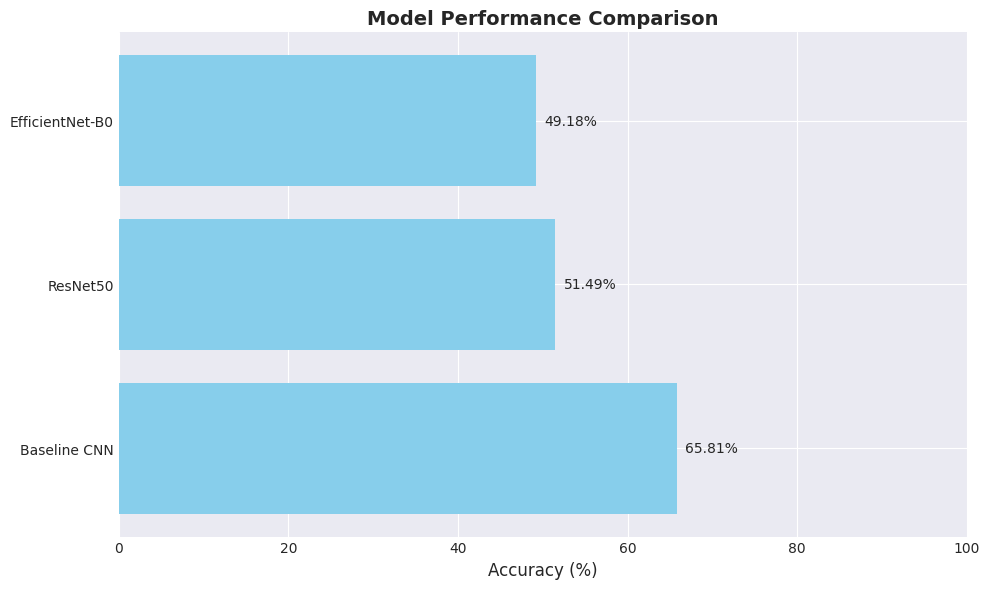

💾 Saved to: /home/steph-grigors/code/steph-grigors/facial-emotion-recognition/results/model_comparison.png


In [11]:
# Visualize comparison
plt.figure(figsize=(10, 6))
plt.barh(comparison_df['Model'], comparison_df['Accuracy'], color='skyblue')
plt.xlabel('Accuracy (%)', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xlim(0, 100)

# Add value labels
for i, (model, acc) in enumerate(zip(comparison_df['Model'], comparison_df['Accuracy'])):
    plt.text(acc + 1, i, f'{acc:.2f}%', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Saved to: {RESULTS_DIR / 'model_comparison.png'}")

## Detailed Analysis: Best Model

In [12]:
# Get best model
best_model_name = comparison_df.iloc[0]['Model']
best_results = results[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {best_results['accuracy']*100:.2f}%")


🏆 Best Model: Baseline CNN
   Accuracy: 65.81%


In [13]:
# Classification report
print("\n📋 Classification Report:")
print("=" * 70)
report = classification_report(
    best_results['labels'],
    best_results['predictions'],
    target_names=CLASS_NAMES,
    digits=3
)
print(report)

# Save report
with open(RESULTS_DIR / f'{best_model_name}_classification_report.txt', 'w') as f:
    f.write(f"Classification Report - {best_model_name}\n")
    f.write("=" * 70 + "\n")
    f.write(report)


📋 Classification Report:
              precision    recall  f1-score   support

       angry      0.526     0.493     0.509       592
     disgust      0.843     0.796     0.818       592
        fear      0.470     0.399     0.431       592
       happy      0.852     0.846     0.849      1140
     neutral      0.595     0.673     0.632       817
         sad      0.467     0.554     0.507       653
    surprise      0.755     0.677     0.714       592

    accuracy                          0.658      4978
   macro avg      0.644     0.634     0.637      4978
weighted avg      0.662     0.658     0.659      4978



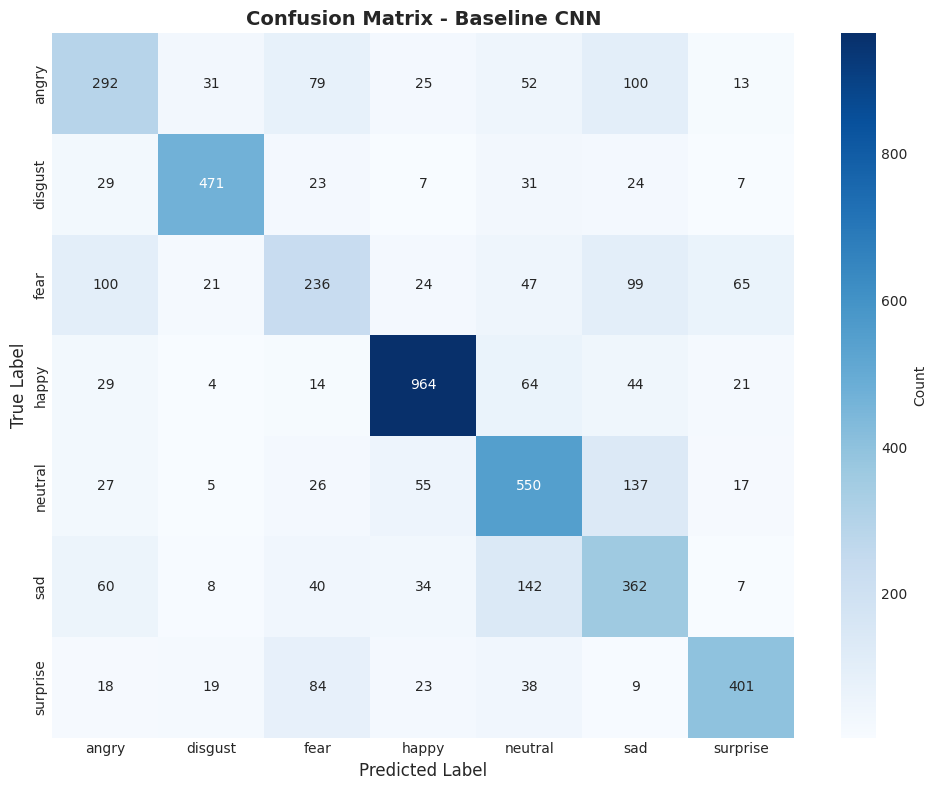

💾 Saved to: /home/steph-grigors/code/steph-grigors/facial-emotion-recognition/results/Baseline CNN_confusion_matrix.png


In [14]:
# Confusion Matrix
cm = confusion_matrix(best_results['labels'], best_results['predictions'])

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    cbar_kws={'label': 'Count'}
)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(RESULTS_DIR / f'{best_model_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Saved to: {RESULTS_DIR / f'{best_model_name}_confusion_matrix.png'}")

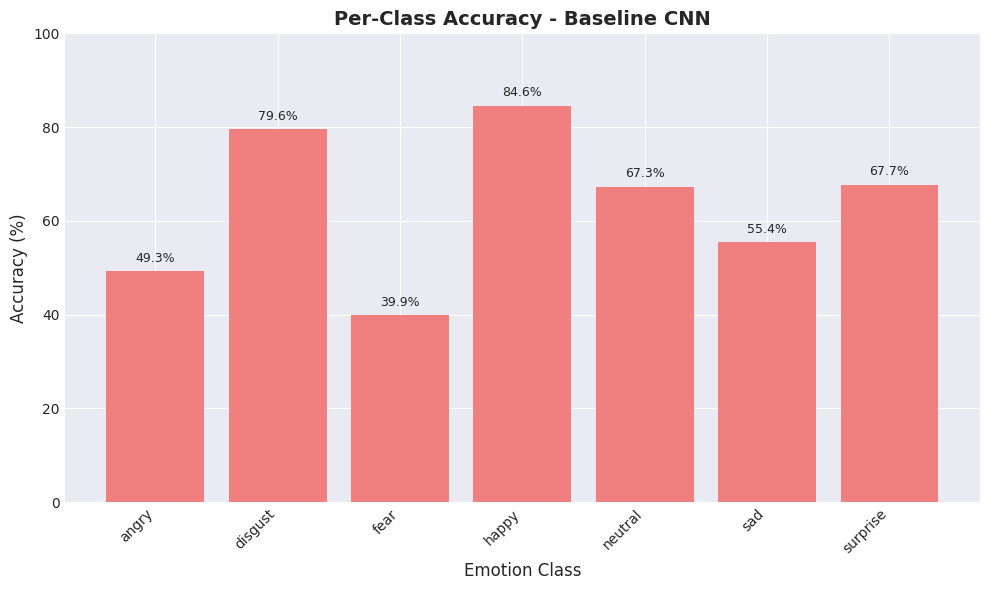

💾 Saved to: /home/steph-grigors/code/steph-grigors/facial-emotion-recognition/results/Baseline CNN_per_class_accuracy.png


In [15]:
# Per-class accuracy
class_correct = np.zeros(NUM_CLASSES)
class_total = np.zeros(NUM_CLASSES)

for label, pred in zip(best_results['labels'], best_results['predictions']):
    class_total[label] += 1
    if label == pred:
        class_correct[label] += 1

class_accuracy = (class_correct / class_total) * 100

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(CLASS_NAMES, class_accuracy, color='lightcoral')
plt.xlabel('Emotion Class', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title(f'Per-Class Accuracy - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')

# Add value labels
for i, (name, acc) in enumerate(zip(CLASS_NAMES, class_accuracy)):
    plt.text(i, acc + 2, f'{acc:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(RESULTS_DIR / f'{best_model_name}_per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Saved to: {RESULTS_DIR / f'{best_model_name}_per_class_accuracy.png'}")

## Compare All Models - Confusion Matrices

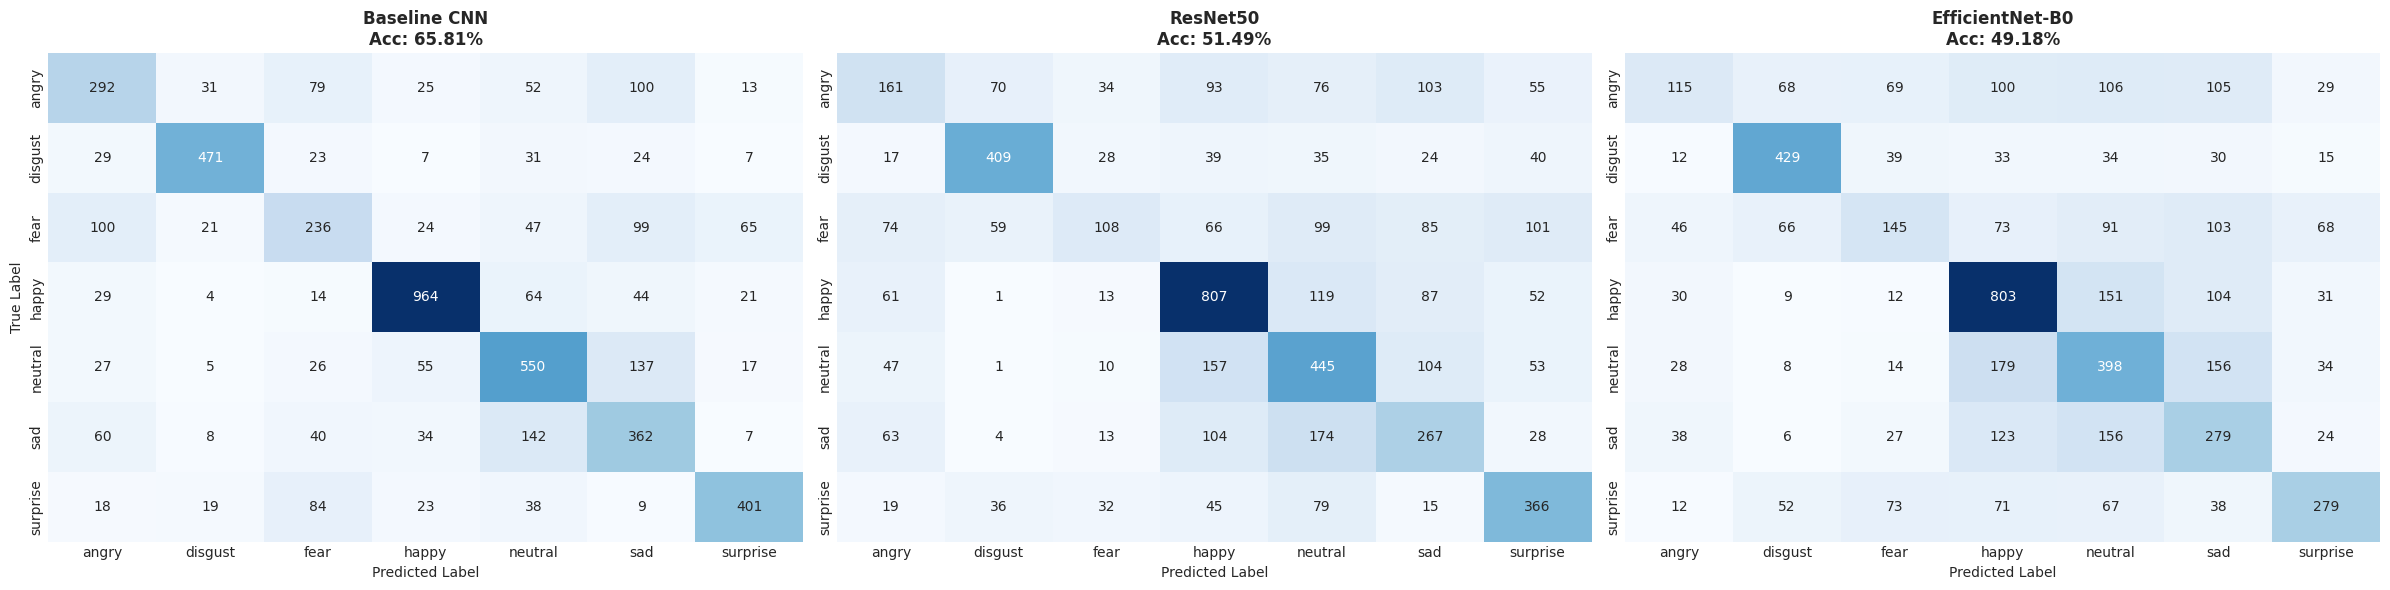

💾 Saved to: /home/steph-grigors/code/steph-grigors/facial-emotion-recognition/results/all_models_confusion_matrices.png


In [16]:
# Create subplot for all confusion matrices
n_models = len(results)
fig, axes = plt.subplots(1, n_models, figsize=(8*n_models, 6))

if n_models == 1:
    axes = [axes]

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(result['labels'], result['predictions'])
    
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES,
        ax=axes[idx],
        cbar=False
    )
    axes[idx].set_title(f'{name}\nAcc: {result["accuracy"]*100:.2f}%', fontweight='bold')
    axes[idx].set_ylabel('True Label' if idx == 0 else '')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'all_models_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Saved to: {RESULTS_DIR / 'all_models_confusion_matrices.png'}")

## Summary Report

In [17]:
# Generate summary
print("\n" + "="*70)
print("📊 FINAL SUMMARY REPORT")
print("="*70)

print(f"\n📁 Dataset:")
print(f"   Test samples: {len(test_dataset)}")
print(f"   Classes: {NUM_CLASSES}")
print(f"   Class names: {', '.join(CLASS_NAMES)}")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {best_results['accuracy']*100:.2f}%")

print(f"\n📈 All Models Performance:")
for _, row in comparison_df.iterrows():
    print(f"   {row['Model']:20s}: {row['Accuracy']:.2f}%")

print(f"\n💾 Results saved to: {RESULTS_DIR}")
print("   - model_comparison.csv")
print("   - model_comparison.png")
print(f"   - {best_model_name}_classification_report.txt")
print(f"   - {best_model_name}_confusion_matrix.png")
print(f"   - {best_model_name}_per_class_accuracy.png")
print("   - all_models_confusion_matrices.png")

print("\n" + "="*70)
print("✅ Analysis Complete!")
print("="*70)


📊 FINAL SUMMARY REPORT

📁 Dataset:
   Test samples: 4978
   Classes: 7
   Class names: angry, disgust, fear, happy, neutral, sad, surprise

🏆 Best Model: Baseline CNN
   Accuracy: 65.81%

📈 All Models Performance:
   Baseline CNN        : 65.81%
   ResNet50            : 51.49%
   EfficientNet-B0     : 49.18%

💾 Results saved to: /home/steph-grigors/code/steph-grigors/facial-emotion-recognition/results
   - model_comparison.csv
   - model_comparison.png
   - Baseline CNN_classification_report.txt
   - Baseline CNN_confusion_matrix.png
   - Baseline CNN_per_class_accuracy.png
   - all_models_confusion_matrices.png

✅ Analysis Complete!


## Next Steps

**You've completed the core pipeline! 🎉**

**Optional enhancements:**
- Train transfer learning models (ResNet50, EfficientNet)
- Add more data augmentation
- Implement ensemble methods
- Create a simple API or web interface
- Add experiment tracking (Weights & Biases, MLflow)

**For your portfolio:**
- Add all visualizations to your README
- Document key findings and model choices
- Include confusion matrices and metrics
- Explain challenges and solutions